In [1]:
########
## @author Vaibhav Bhilare
## @copyright 2017, Vaibhav Bhilare
## Application of Q-Learning to teach an agent to play Tic-Tac-Toe from scratch
########

## Imports
import random
import operator
import pickle

## Class for Game
class TicTacToe:
    def __init__(self, playerX, playerO):
        self.board = [' ']*9
        self.playerX, self.playerO = playerX, playerO
        self.playerX_turn = random.choice([True, False])

    def Game(self,X_Wins,O_Wins,Game_Type):
        self.playerX.Character('X')
        self.playerO.Character('O')
        while True:
            if self.playerX_turn:
                player, char, other_player = self.playerX, 'X', self.playerO
            else:
                player, char, other_player = self.playerO, 'O', self.playerX
            if player.Player_Type == "human":
                self.display_board()
            if Game_Type=='Q_Table':  ## Q-Table Game
                space = player.move(self.board,char)
            elif Game_Type=='Neural_Network':  ## Neural Network Game
                space = player.move_NN(self.board,char)
            if self.board[space-1] != ' ':  ## Illegal move
                player.reward(-99, self.board)
                return X_Wins,O_Wins
                break
            self.board[space-1] = char
            if self.player_wins('X'):  ## X Wins the Game
                X_Wins=X_Wins+1
                player=self.playerX
                player.reward(1, self.board)  ## +1 Reward for Winning
                other_player.reward(-1, self.board)
                return X_Wins,O_Wins
                break
            elif self.player_wins('O'):  ## O Wins the Game
                O_Wins=O_Wins+1
                player=self.playerO
                player.reward(1, self.board)
                other_player.reward(-1, self.board)  ## -1 Reward for losing
                return X_Wins,O_Wins
                break
            if self.board_full():  ## Draw
                player=self.playerX
                player.reward(0, self.board)  ## 0 Reward for Draw
                other_player.reward(0, self.board)
                if Print_Winner==True:
                    self.display_board()
                    print('Draw!')
                return X_Wins,O_Wins
                break
            other_player.reward(0, self.board)
            self.playerX_turn = not self.playerX_turn

    def player_wins(self, char):
        for a,b,c in [(0,1,2), (3,4,5), (6,7,8),
                      (0,3,6), (1,4,7), (2,5,8),
                      (0,4,8), (2,4,6)]:
            if char == self.board[a] == self.board[b] == self.board[c]:
                if Print_Winner==True:
                    self.display_board()
                    print('Player {} Wins!'.format(char))
                return True
        return False

    def board_full(self):
        return not any([space == ' ' for space in self.board])

    def display_board(self):
        Row = " {} | {} | {}"
        Column = "\n-----------\n"
        print((Row + Column + Row + Column + Row).format(*self.board))


class Player(object):
    def __init__(self):
        self.Player_Type = "human"

    def Character(self, char):
        print("\nNew game!")

    def move(self, board, char):
        return int(input("Your Move? "))
    
    def move_NN(self, board, char):
        return int(input("Your Move?"))

    def reward(self, value, board):
        pass

    def available_moves(self, board):
        return [i+1 for i in range(0,9) if board[i] == ' ']


class Q_Learning_Player(Player):
    def __init__(self, epsilon=1, alpha=0.01, gamma=0.9):
        self.Player_Type = "Qlearner"
        self.epsilon = epsilon  ## Exploration Factor
        self.alpha = alpha  ## learning Rate
        self.gamma = gamma  ## Discount Factor for Future Rewards

    def Character(self, char):
        self.last_board = (' ',)*9
        self.last_move = None

    def getQ(self, state, action):
        if q.get((state, action)) is None:  ## If (State,Action) pair not present in Q-Table, Initialize to 0 
            q[(state, action)] = 0.0
        return q.get((state, action))
    
    def getQ_NN(self, state, action):
        State_List=[]
        Action=[0] * 9
        for Slot in state:
            if Slot==' ':
                Slot=-1
            if Slot=='X':
                Slot=0
            if Slot=='O':
                Slot=1
            #print(Slot)
            State_List.append(Slot)
        Action[action-1]=1
        State_Action=State_List+Action
        Quality_List=clf.predict(np.array(State_Action).reshape(1,-1))
        Quality_List=Quality_List.tolist()
        max_value = max(Quality_List)
        return max_value
        
    def move(self, board, char):
        if self.Player_Type=='Qlearner' and Print_Winner==True:
            print('Q_Learning Player Thinking...')
        self.last_board = tuple(board)
        actions = self.available_moves(board)

        if random.random() < self.epsilon:
            self.last_move = random.choice(actions)
            return self.last_move

        qs = [self.getQ(self.last_board, a) for a in actions]
        if char=='X':
            maxQ = max(qs)
        else:
            maxQ = max(qs) # min(qs)

        if qs.count(maxQ) > 1:
            best_options = [i for i in range(len(actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = qs.index(maxQ)

        self.last_move = actions[i]
        return actions[i]
    
    def move_NN(self, board, char):
        if Print_Winner==True:
            print('Neural_Network Player Thinking...')
        self.last_board = tuple(board)
        actions = self.available_moves(board)
        qs= [self.getQ_NN(self.last_board, a) for a in actions]
        maxQ = max(qs)
        if qs.count(maxQ) > 1:
            print('Confused')
            best_options = [i for i in range(len(actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
            print(i)
        else:
            i = qs.index(maxQ)

        self.last_move = actions[i]
        return actions[i]

    def reward(self, value, board):
        if self.last_move:
            self.learn(self.last_board, self.last_move, value, tuple(board))

    def learn(self, state, action, reward, result_state):
        prev = self.getQ(state, action)
        maxqnew = max([self.getQ(result_state, a) for a in self.available_moves(state)])
        q[(state, action)] = prev + self.alpha * ((reward + self.gamma*maxqnew) - prev)
        
    def reward_intermediate(self,value,board):
        if self.last_move:
            self.learn_intermediate(self.last_board, self.last_move, value, tuple(board))
    
    def learn_intermediate(self,state,action,reward,result_state):
        prev = self.getQ(state, action)
        maxqnew = max([self.getQ(result_state, a) for a in self.available_moves(state)])
        q[(state, action)] = prev + self.alpha * ((reward + self.gamma*maxqnew) - prev)


p1 = Q_Learning_Player()
p2 = Q_Learning_Player()
Print_Winner=False
q = {} # (state, action) keys: Q values
global X_Wins
global O_Wins
X_Wins=0
O_Wins=0
Game_Type='Q_Table'

Training_Input=input('Train the Q Learner?(Y/N)')
if Training_Input=='Y':
    Games_Input=input('How Many Games of Self-Play?')
    for i in range(1,int(Games_Input)):
        Play= TicTacToe(p1, p2)
        #p1.epsilon=max(p1.epsilon*0.999,0.02)
        #p2.epsilon=max(p2.epsilon*0.999,0.02)
        X_Wins,O_Wins=Play.Game(X_Wins,O_Wins,Game_Type)
        if i%20000==0:
            print(('Iterations: {}, X_Wins: {:0.2f}%, O_Wins: {:0.2f}%, Draws%: {:0.2f}% ').format(i,
                                        X_Wins/200,O_Wins/200,100-((X_Wins+O_Wins)/200)))
            X_Wins=0
            O_Wins=0
else:
    print('Loading Saved Model...')
    pickle_in = open("Q_Table.pickle","rb")
    q = pickle.load(pickle_in)

p2 = Player()
p1.epsilon = 0
Print_Winner=True



# while True:
#     user_input=input('Play Game?(Y,N)')
#     if user_input=='N':
#         break
#    Play= TicTacToe(p1, p2)
#     Play.Game(X_Wins,O_Wins,Game_Type)

Train the Q Learner?(Y/N)Y
How Many Games of Self-Play?500000
Iterations: 20000, X_Wins: 43.49%, O_Wins: 44.08%, Draws%: 12.43% 
Iterations: 40000, X_Wins: 43.68%, O_Wins: 43.37%, Draws%: 12.95% 
Iterations: 60000, X_Wins: 43.88%, O_Wins: 43.45%, Draws%: 12.67% 
Iterations: 80000, X_Wins: 43.48%, O_Wins: 43.80%, Draws%: 12.72% 
Iterations: 100000, X_Wins: 43.69%, O_Wins: 43.48%, Draws%: 12.83% 
Iterations: 120000, X_Wins: 43.38%, O_Wins: 44.09%, Draws%: 12.53% 
Iterations: 140000, X_Wins: 43.45%, O_Wins: 43.45%, Draws%: 13.11% 
Iterations: 160000, X_Wins: 43.41%, O_Wins: 43.87%, Draws%: 12.72% 
Iterations: 180000, X_Wins: 43.23%, O_Wins: 43.83%, Draws%: 12.95% 
Iterations: 200000, X_Wins: 43.94%, O_Wins: 43.36%, Draws%: 12.70% 
Iterations: 220000, X_Wins: 43.61%, O_Wins: 43.42%, Draws%: 12.97% 
Iterations: 240000, X_Wins: 44.07%, O_Wins: 43.31%, Draws%: 12.61% 
Iterations: 260000, X_Wins: 42.97%, O_Wins: 44.22%, Draws%: 12.81% 
Iterations: 280000, X_Wins: 43.62%, O_Wins: 43.92%, Draws%

In [2]:
# # Write Pickle
# f = open("Q_Table.pickle","wb")
# pickle.dump(q, f)
# f.close()
# Master=q
# del q

In [3]:
# # Read Pickle
# pickle_in = open("Q_Table.pickle","rb")
# q = pickle.load(pickle_in)

# ## Below This -> Debug
# # shared_items = set(Master.items()) & set(q.items())
# # print(len(shared_items))
print(len(q))

75219


In [4]:
## Play Against Q-Learning Player

while True:
    user_input=input('Play Game?(Y,N)')
    if user_input=='N':
        break
    Play= TicTacToe(p1, p2)
    Play.Game(X_Wins,O_Wins,Game_Type)

Play Game?(Y,N)Y

New game!
   |   |  
-----------
   |   |  
-----------
   |   |  
Your Move? 5
Q_Learning Player Thinking...
 X |   |  
-----------
   | O |  
-----------
   |   |  
Your Move? 6
Q_Learning Player Thinking...
 X |   |  
-----------
 X | O | O
-----------
   |   |  
Your Move? 7
Q_Learning Player Thinking...
 X |   | X
-----------
 X | O | O
-----------
 O |   |  
Your Move? 2
Q_Learning Player Thinking...
 X | O | X
-----------
 X | O | O
-----------
 O | X |  
Your Move? 9
 X | O | X
-----------
 X | O | O
-----------
 O | X | O
Draw!
Play Game?(Y,N)N


In [5]:
import numpy as np
Temp_q=q
New_q=[]
Y_Train=[]
for key in Temp_q:
    if Temp_q[key]!=0:
        #print(key)
        State_Tuple=key[0]
        State_List=[]
        Action=[0] * 9
        for Slot in State_Tuple:
            if Slot==' ':
                Slot=-1
            if Slot=='X':
                Slot=0
            if Slot=='O':
                Slot=1
            #print(Slot)
            State_List.append(Slot)
        Action[key[1]-1]=1
        State_Action=State_List+Action
        Temp_Y_Multi=Temp_q[key]
        New_q.append([State_Action,Temp_Y_Multi])
        Y_Train.append(Temp_q[key])
        #print(Temp_q[key])
# print(New_q,Y_Train)
# print(len(New_q))
# print(len(Y_Train))
training_data=New_q
X = np.array([i[0] for i in training_data])
Y = [i[1] for i in training_data]
# print(Y)
# print(Action)
# print(len(X[0]))
# print(min(Y))
# print(max(Y))
# print(((Y[0])-min(Y))/(max(Y)-min(Y)))

In [6]:
from sklearn import preprocessing
Y_Train=np.reshape(Y,(-1,))
Y_Train=preprocessing.scale(Y_Train)

In [7]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(solver='adam', alpha=1e-3,learning_rate_init=0.001,verbose=True,activation='relu',tol=1e-5,
                    hidden_layer_sizes=(325,325,325), random_state=1,learning_rate='adaptive',max_iter=200)
clf.fit(X, Y_Train)

Iteration 1, loss = 0.48710978
Iteration 2, loss = 0.45886756
Iteration 3, loss = 0.42962369
Iteration 4, loss = 0.38085323
Iteration 5, loss = 0.31995340
Iteration 6, loss = 0.27159994
Iteration 7, loss = 0.22224577
Iteration 8, loss = 0.19003420
Iteration 9, loss = 0.16634227
Iteration 10, loss = 0.14176514
Iteration 11, loss = 0.12250096
Iteration 12, loss = 0.10622097
Iteration 13, loss = 0.09104919
Iteration 14, loss = 0.08279620
Iteration 15, loss = 0.07824251
Iteration 16, loss = 0.06922519
Iteration 17, loss = 0.06155733
Iteration 18, loss = 0.05589023
Iteration 19, loss = 0.05247630
Iteration 20, loss = 0.04878741
Iteration 21, loss = 0.04563115
Iteration 22, loss = 0.04193824
Iteration 23, loss = 0.04047862
Iteration 24, loss = 0.03810414
Iteration 25, loss = 0.03540294
Iteration 26, loss = 0.03305733
Iteration 27, loss = 0.03102810
Iteration 28, loss = 0.03099878
Iteration 29, loss = 0.02960099
Iteration 30, loss = 0.02766132
Iteration 31, loss = 0.02691896
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(325, 325, 325), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=1e-05, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [8]:
# # # Write Pickle Neural Network
# f = open("Neural_Network.pickle","wb")
# pickle.dump(clf, f)
# f.close()

# # # Load Pickle Neural Network
# pickle_in = open("Neural_Network.pickle","rb")
# clf = pickle.load(pickle_in)

In [9]:
p2 = Player()
p1.epsilon = 0
Print_Winner=True
Game_Type='Neural_Network'
while True:
    user_input=input('Play Game?(Y,N)')
    if user_input=='N':
        break
    Play= TicTacToe(p1, p2)
    Play.Game(X_Wins,O_Wins,Game_Type)

Play Game?(Y,N)Y

New game!
   |   |  
-----------
   |   |  
-----------
   |   |  
Your Move?5
Neural_Network Player Thinking...
 X |   |  
-----------
   | O |  
-----------
   |   |  
Your Move?7
Neural_Network Player Thinking...
 X |   | X
-----------
   | O |  
-----------
 O |   |  
Your Move?2
Neural_Network Player Thinking...
 X | O | X
-----------
   | O |  
-----------
 O | X |  
Your Move?6
Neural_Network Player Thinking...
 X | O | X
-----------
 X | O | O
-----------
 O | X |  
Your Move?9
 X | O | X
-----------
 X | O | O
-----------
 O | X | O
Draw!
Play Game?(Y,N)N


In [10]:
clf.score(X,Y_Train)

0.96601687976240169

In [11]:
from sklearn.metrics import explained_variance_score
explained_variance_score(Y_Train, clf.predict(X), multioutput='uniform_average')

0.96608274153626372

In [12]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_Train, clf.predict(X), multioutput='raw_values')

array([ 0.14103745])

In [13]:
clf.predict(X[0].reshape(1,-1))

array([-0.69087484])

In [14]:
X_Wins=0
O_Wins=0
p1 = Q_Learning_Player()
p2 = Q_Learning_Player()
p1.epsilon=0
p1.gamma=0
p1.alpha=0
p2.epsilon=0
p2.gamma=0
p2.alpha=0
Game_Type='Neural_Network'
Print_Winner=False
for i in range(1,100001):
    Play= TicTacToe(p1, p2)
    #p1.epsilon=max(p1.epsilon*0.999,0.02)
    #p2.epsilon=max(p2.epsilon*0.999,0.02)
    X_Wins,O_Wins=Play.Game(X_Wins,O_Wins,Game_Type)
    if i%20000==0:
        print(('Iterations: {}, X_Wins: {:0.2f}%, O_Wins: {:0.2f}%, Draws%: {:0.2f}% ').format(i,
                                    X_Wins/200,O_Wins/200,100-((X_Wins+O_Wins)/200)))
        X_Wins=0
        O_Wins=0

Iterations: 20000, X_Wins: 0.00%, O_Wins: 0.00%, Draws%: 100.00% 
Iterations: 40000, X_Wins: 0.00%, O_Wins: 0.00%, Draws%: 100.00% 
Iterations: 60000, X_Wins: 0.00%, O_Wins: 0.00%, Draws%: 100.00% 
Iterations: 80000, X_Wins: 0.00%, O_Wins: 0.00%, Draws%: 100.00% 
Iterations: 100000, X_Wins: 0.00%, O_Wins: 0.00%, Draws%: 100.00% 


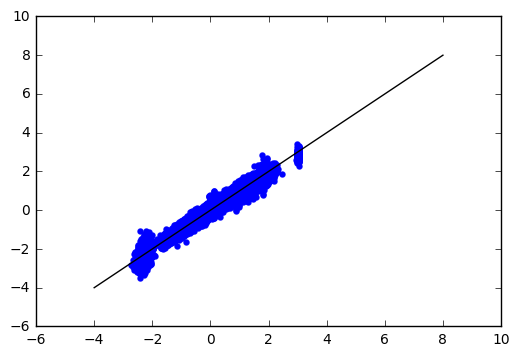

In [15]:
import matplotlib.pyplot as plt
#plt.plot(Y_Train,  color='black')
plt.scatter(Y_Train,clf.predict(X), color='blue',
         linewidth=0.1)
plt.plot([-4,8],[-4,8],color='black')
plt.title="Predicted Values vs Target values"
plt.xlabel=("Targets")
plt.ylabel=("Predicted")
plt.savefig('Accuracy.png')
plt.show()